In [1]:
import os
import sys
import optuna
import torch
from torchinfo import summary
from torchvision.transforms import v2
from torch.utils.data import DataLoader
module_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(module_dir))


from modules.data import PhoneDataset
from modules.models import ConvolutionalLocator
from modules.training import EarlyStopping, ModelTrainer
from modules.transforms import (
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomTranslation
)
from modules.utilities import (
    get_data,
    visualize_augmentations,
    train_test_split
)

/home/nicolas/anaconda3/envs/ml-python311/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nicolas/anaconda3/envs/ml-python311/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

In [2]:
folder = os.path.join('..', 'find_phone_data')
seed = 0
test_size = 0.1
batch_size = 128
patience = 5
min_delta = 0.0
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
epochs = 50
lr = 1e-2

In [3]:
image_paths, locations = get_data(folder)
print(image_paths[0])
print(locations[os.path.basename(image_paths[0])])

../find_phone_data/51.jpg
(0.2388, 0.6012)


In [4]:
train_image_paths, test_image_paths, train_locations, test_locations = train_test_split(
    image_paths, locations, test_size, seed
)
print(train_image_paths[0])
print(train_locations[os.path.basename(train_image_paths[0])])

../find_phone_data/27.jpg
(0.6245, 0.3067)


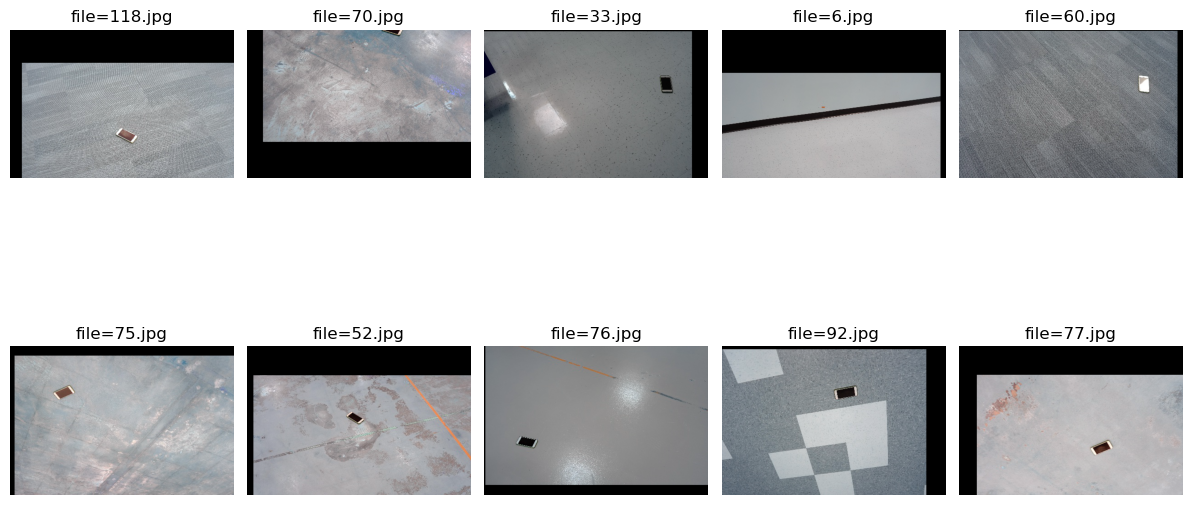

In [5]:
aware_transforms = v2.Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomTranslation(),
])
train_dataset = PhoneDataset(train_image_paths, train_locations, aware_transforms)
test_dataset = PhoneDataset(test_image_paths, test_locations)
visualize_augmentations(train_dataset, train_locations, random_img=True)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([116, 3, 326, 490]) torch.float32
Shape of y: torch.Size([116, 2]) torch.float32


In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

early_stopping = EarlyStopping(15)

model_trainer = ModelTrainer(
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer,
    early_stopping,
    scheduler,
    device
)

In [8]:
def objective(trial) -> float:
    """
    Define a objective function for a hyper-parameter optimization task.

    trial: optuna.trial.Trial
        A Trial instance from optuna. Is set automatically.

    Return
    ------
    score: float
        The score on the test set of the model trained with the hyper-parameters
        given by trial.
    """
    c_in = 3
    h_in, w_in = 326, 490
    c_out_factor = trial.suggest_int('c_out_factor', 2, 4)

    conv_init_kernel_size = trial.suggest_int('conv_init_kernel_size', 4, 9)
    conv_kernel_size = trial.suggest_int('conv_kernel_size', 2, 5)
    conv_stride = trial.suggest_int('conv_stride', 2, 5)
    conv_padding = trial.suggest_int('conv_padding', 0, int(conv_kernel_size/2))
    conv_dilation = trial.suggest_int('conv_dilation', 1, 5)

    pool_kernel_size = trial.suggest_int('pool_kernel_size', 2, 5)
    pool_stride = trial.suggest_int('pool_stride', 2, 5)
    pool_padding = trial.suggest_int('pool_padding', 0, int(pool_kernel_size/2))
    pool_dilation = trial.suggest_int('pool_dilation', 1, 5)

    conv_depth = trial.suggest_int('conv_depth', 3, 8)
    dense_depth = trial.suggest_int('dense_depth', 2, 5)

    p = trial.suggest_float('p', 0.1, 0.6)

    model = ConvolutionalLocator(
        c_in,
        h_in,
        w_in,
        conv_depth,
        dense_depth,
        c_out_factor,
        conv_init_kernel_size,
        conv_kernel_size,
        conv_stride,
        conv_padding,
        conv_dilation,
        pool_kernel_size,
        pool_stride,
        pool_padding,
        pool_dilation,
        p
    )

    model_trainer(epochs, model, lr, silent=True)
    model.eval()
    score = 0
    size = len(test_dataloader.dataset)
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        score += loss_fn(pred, y).item()
    return score / size

In [9]:
sampler =  optuna.samplers.TPESampler(
    seed=seed, multivariate=True, constant_liar=True,
    warn_independent_sampling=False
)
pruner =  optuna.pruners.HyperbandPruner()
n_trials = 50

study = optuna.create_study(
    direction='minimize', sampler=sampler, pruner=pruner,
    study_name='phone-model', load_if_exists=True
)

study.optimize(
    objective, n_trials=n_trials, timeout=15*n_trials, n_jobs=1,
    show_progress_bar=True, gc_after_trial=True, catch=(RuntimeError)
)

/home/nicolas/anaconda3/envs/ml-python311/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/nicolas/anaconda3/envs/ml-python311/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:314: ExperimentalWarning: ``constant_liar`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-02-05 21:19:22,385] A new study created in memory with name: phone-model


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-05 21:24:47,881] Trial 0 finished with value: 0.1692792268899771 and parameters: {'c_out_factor': 3, 'conv_init_kernel_size': 8, 'conv_kernel_size': 4, 'conv_stride': 4, 'conv_padding': 1, 'conv_dilation': 4, 'pool_kernel_size': 3, 'pool_stride': 5, 'pool_padding': 1, 'pool_dilation': 2, 'conv_depth': 7, 'dense_depth': 4, 'p': 0.3840222805469662}. Best is trial 0 with value: 0.1692792268899771.
[I 2024-02-05 21:32:13,146] Trial 1 finished with value: 0.33177764599139875 and parameters: {'c_out_factor': 4, 'conv_init_kernel_size': 4, 'conv_kernel_size': 2, 'conv_stride': 2, 'conv_padding': 1, 'conv_dilation': 4, 'pool_kernel_size': 5, 'pool_stride': 5, 'pool_padding': 2, 'pool_dilation': 3, 'conv_depth': 7, 'dense_depth': 2, 'p': 0.41996051066376194}. Best is trial 0 with value: 0.1692792268899771.


In [10]:
best_params = study.best_params
best_params

{'c_out_factor': 3,
 'conv_init_kernel_size': 8,
 'conv_kernel_size': 4,
 'conv_stride': 4,
 'conv_padding': 1,
 'conv_dilation': 4,
 'pool_kernel_size': 3,
 'pool_stride': 5,
 'pool_padding': 1,
 'pool_dilation': 2,
 'conv_depth': 7,
 'dense_depth': 4,
 'p': 0.3840222805469662}

In [11]:
c_in = 3
h_in, w_in = 326, 490
c_out_factor = best_params['c_out_factor']
conv_init_kernel_size = best_params['conv_init_kernel_size']
conv_kernel_size = best_params['conv_kernel_size']
conv_stride = best_params['conv_stride']
conv_padding = best_params['conv_padding']
conv_dilation = best_params['conv_dilation']
pool_kernel_size = best_params['pool_kernel_size']
pool_stride = best_params['pool_stride']
pool_padding = best_params['pool_padding']
pool_dilation = best_params['pool_dilation']
conv_depth = best_params['conv_depth']
dense_depth = best_params['dense_depth']
p = best_params['p']

In [12]:
model = ConvolutionalLocator(
    c_in,
    h_in,
    w_in,
    conv_depth,
    dense_depth,
    c_out_factor,
    conv_init_kernel_size,
    conv_kernel_size,
    conv_stride,
    conv_padding,
    conv_dilation,
    pool_kernel_size,
    pool_stride,
    pool_padding,
    pool_dilation,
    p
)

summary(
    model=model,
    input_size=(batch_size, c_in, h_in, w_in),
    col_names=["input_size", "output_size", "num_params"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #
ConvolutionalLocator (ConvolutionalLocator)   [128, 3, 326, 490]   [128, 2]             --
├─Sequential (convolutional_stack)            [128, 3, 326, 490]   [128, 27, 2, 4]      --
│    └─Conv2d (0)                             [128, 3, 326, 490]   [128, 9, 75, 116]    1,737
│    └─ReLU (1)                               [128, 9, 75, 116]    [128, 9, 75, 116]    --
│    └─BatchNorm2d (2)                        [128, 9, 75, 116]    [128, 9, 75, 116]    18
│    └─Dropout2d (3)                          [128, 9, 75, 116]    [128, 9, 75, 116]    --
│    └─MaxPool2d (4)                          [128, 9, 75, 116]    [128, 9, 15, 23]     --
│    └─Conv2d (5)                             [128, 9, 15, 23]     [128, 27, 2, 4]      3,915
│    └─ReLU (6)                               [128, 27, 2, 4]      [128, 27, 2, 4]      --
│    └─BatchNorm2d (7)                        [128, 27, 2, 4]      [128, 27, 2,

In [13]:
model_trainer(epochs, model, lr)

Epoch 1
-------------------------------
loss: 67.883720  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.587001 

Epoch 2
-------------------------------
loss: 72.548958  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.540968 

Epoch 3
-------------------------------
loss: 61.817913  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.488345 

Epoch 4
-------------------------------
loss: 76.789780  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.439614 

Epoch 5
-------------------------------
loss: 72.379410  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.384262 

Epoch 6
-------------------------------
loss: 62.119705  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.307448 

Epoch 7
-------------------------------
loss: 66.645058  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.198787 

Epoch 8
-------------------------------
loss: 63.400627  [  116/  116]
Test Error: 
 Accuracy: 0.0%, Avg loss: 7.103415 

Epoch 9
----------------

In [14]:
model.eval()
train_size = len(train_dataloader.dataset)
train_correct = 0
for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    correct = (torch.sum((y - pred)**2, dim=-1) < 0.05)
    train_correct += correct.type(torch.float).sum().item()

test_size = len(test_dataloader.dataset)
test_correct = 0
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    correct = (torch.sum((y - pred)**2, dim=-1) < 0.05)
    test_correct += correct.type(torch.float).sum().item()

print(f'Train set accuracy: {train_correct / train_size}')
print(f'Test set accuracy: {test_correct / test_size}')

Train set accuracy: 0.0
Test set accuracy: 0.0
